In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
import numpy as np
from itertools import tee
from gui.user_code import pairwise_randomised_significance, get_data_for_signif_test
from gui.output_utils import get_cv_fold_count, get_cv_scores_many_experiment
from gui.constants import CLASSIFIER

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


# Does the classification evaluation framework work?
What is the effect of adding uniform random noise to vectors? Can our experiments tell between a set of vectors and a corrupted version of the same vectors? To find out, add uniform random noise from $-n$ to $n$ (x axis) to all non-zero entries in a set of `word2vec` embeddings.
     

experiments are [97, 145, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
noise 0.00, acc 0.23
noise 0.00, acc 0.23
noise 0.20, acc 0.22
noise 0.40, acc 0.21
noise 0.60, acc 0.23
noise 0.80, acc 0.22
noise 1.00, acc 0.19
noise 1.20, acc 0.20
noise 1.40, acc 0.21
noise 1.60, acc 0.20
noise 1.80, acc 0.22
noise 2.00, acc 0.22
Calculating CI for exp 97: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 145: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 74: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 75: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 76: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 77: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 78: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 79: amazon_grouped-tagged,Vectors 58:word2vec,Add,100,100
Calculating CI for exp 80: amazon

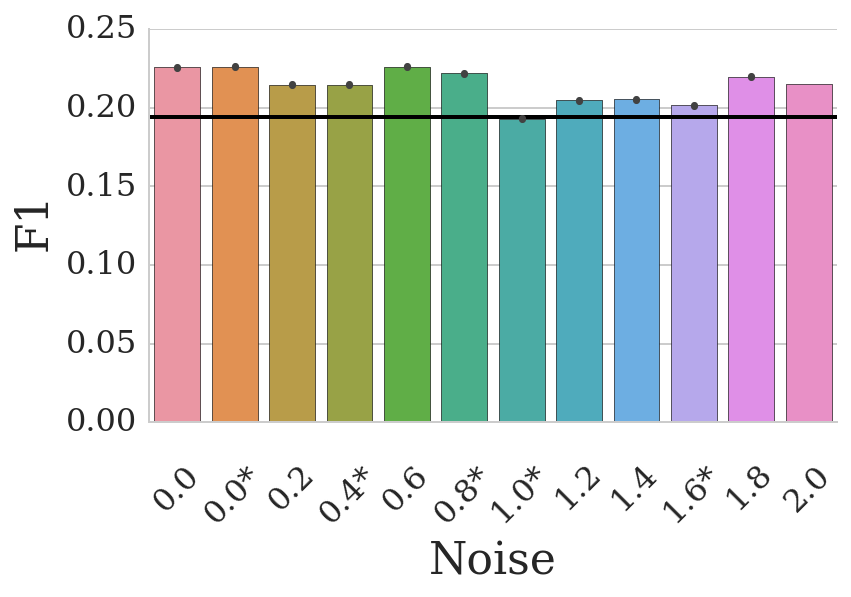

In [2]:
d = {'vectors__unlabelled_percentage': 100,
     'labelled': 'amazon_grouped-tagged',
     'vectors__dimensionality': 100,
     'decode_handler': 'SignifiedOnlyFeatureHandler',
     'vectors__composer': 'Add',
     'vectors__rep': 0, 
     'allow_overlap': False,
     'k': 3,
     'vectors__unlabelled': 'wiki',
     'vectors__algorithm': 'word2vec',
     'document_features_tr': 'J+N+AN+NN',
     'document_features_ev': 'AN+NN'}
e = Experiment.objects.filter(**d).order_by('noise').values_list('id', flat=True)
print('experiments are', e)

for eid in e:
    print('noise %2.2f, acc %2.2f'%(Experiment.objects.get(id=eid).noise,
                                    Results.objects.get(id=eid, classifier=CLASSIFIER).accuracy_mean))
    
cv_folds = get_cv_fold_count(e)
scores, folds = get_cv_scores_many_experiment(e)
raw_names = ['%1.1f'%x for x in Experiment.objects.filter(id__in=e).order_by('noise').values_list('noise', flat=True)]

# calculate significance
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

print('ids', e, 'names', raw_names)
for i, (e1, e2) in enumerate(pairwise(e)):
    # TODO need bonferoni correction     
    statistic, pval = pairwise_randomised_significance(get_data_for_signif_test(e1),
                                            get_data_for_signif_test(e2))
    if pval < 0.05:
        # significant difference exists
        raw_names[i] += '*'

names = np.repeat(raw_names, cv_folds)
df = pd.DataFrame(dict(Noise=names, F1=scores, folds=folds))
ax = sns.factorplot('Noise', 'F1', data=df, kind='bar', aspect=1.5);
ax.set_xticklabels(rotation=45);

# random baseline for comparison
rand = Experiment.objects.get(vectors__algorithm='random_vect', labelled='amazon_grouped-tagged').id
score, score_std = Results.objects.get(id=rand, 
                                          classifier='MultinomialNB').get_performance_info()
plt.hlines(score, -100, 100)
plt.savefig('plot-noise-gigaword-add.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [14]:
Results.objects.get(id=114, classifier=CLASSIFIER).accuracy_mean

0.2256911191981102

In [15]:
Results.objects.get(id=99, classifier=CLASSIFIER).accuracy_mean

0.20417544531698908